# Time-series forecasting: Rolling multi-step forecasts with Recurrent Neural Networks
Recurrent Neural Networks (RNN, LSTM, GRU) are capable of learning long-term dependencies from the input sequence, support additional exogeneous features as input. Looking at the results below, they are really good at time-series forecasting out of the box with minimal feature engineering! However, RNNs are also rather tricky to work with since they take in a 3D input, which may be hard to visualize for beginners. I hope this notebook provides sufficient code for you to adapt in your own work, but do let me know if you have any uncertainties: I can be reached here, or via [GitHub](https://github.com/mingboi95)


![img](https://github.com/mingboi95/forecasting/raw/main/Summary.jpg?raw=true)


For the sake of simplicity, a very simple train-test split is used, with data down-sampled to daily frequency for ease of interpretation. 
This notebook serves as a guide for forecasting time-series with Deep Learning methods, and it implements the following:
- Multiple input features (multivariate time-series forecasting)
- Multi-step forecasting (multivariate, multi-step time-series forecasting)



# 1. Loading the Data

The helper evaluation functions are available [here](https://www.kaggle.com/mingboi/rnn-utils)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

from sklearn.preprocessing import MinMaxScaler
from rnn_utils import mae, mse, rmse, mape, evaluate # helper evaluation functions
from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

In [2]:
FILE_PATH = "/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt"
df = pd.read_csv(FILE_PATH, sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)
df.head()

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Attribute Information

1. ds: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. globalactivepower: household global minute-averaged active power (in kilowatt)

4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [3]:
print(f"Missing values: {df.isnull().sum().any()}")
# imputation with the columns means
for j in range(0,8):        
  df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
# checking for missing values
print(f"Missing values: {df.isnull().sum().any()}")

Missing values: True
Missing values: False


We do some pre-processing to frame this problem properly:
- Downsampling from minute-average activate power to daily active power for households
- Imputation missing values with column mean
- MinMax Normalization to preserve variable distributions for our Recurrent Neural Networks

The dataset is now daily France household electricity data from `2006-12-23` until `2010-11-26`

In [4]:
df_resample = df.resample('D', on='ds').sum() 
df_resample.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample = df_resample[['y']]
df_resample.head()

,y
ds,
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


# 2. Pre-processing

Recurrent Neural Networks can take in additional features as a 3-D array for input, so to illustrate here we have some helper functions that help to create some simple lagged features to add into our model. You incorporate more complicated time-series features here in your own work.

In [5]:
def create_lags(df, days=7):
    # create lagged data for features
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['y'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=7):
    # create 3d dataset for input
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    # yhat needs to be scaled
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['y']
    date_idx = pd.date_range(start='2006-12-23', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

We preprocess by normalizing all variables first, taking care to avoid data leakage by using our MinMaxScaler on training data only

In [6]:
chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

# Fit scaler on training data only to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:1096,1:])
scaler_y = scaler.fit(chosen.iloc[:1096,0].values.reshape(-1,1))

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)
print(scaled.shape)
scaled.head()

(1435, 8)


,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
ds,,,,,,,,
2006-12-23,0.462304,0.324670,0.436748,0.313037,0.431901,0.694252,0.211996,1.000000
2006-12-24,1.000000,0.462304,0.324670,0.436748,0.313037,0.431901,0.694252,0.508439
2006-12-25,0.508439,1.000000,0.462304,0.324670,0.436748,0.313037,0.431901,0.551133
2006-12-26,0.551133,0.508439,1.000000,0.462304,0.324670,0.436748,0.313037,0.814446
2006-12-27,0.814446,0.551133,0.508439,1.000000,0.462304,0.324670,0.436748,0.282652


### Train-val-test split

We a simple train-test split for illustration purposes, where we predict for values from `2010-06-01` onwards for the test set.

Train - `2006-12-23` - `2009-12-22`  
Val - `2009-12-23` - `2010-05-31`  
Test - `2010-06-01` - `2010-11-26`

In [7]:
train = scaled[:1096]
val = scaled[1096:1256]
test = scaled[1256:]
x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [8]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
#print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]
#print(y_train.shape, y_val.shape, y_test.shape)

# 3. Forecasting with Recurrent Neural Networks
Here's a helper function to help us train our RNNs, LSTMs, GRUs, where we then forecast with them to get the normalized predictions

In [9]:
def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    #model.add(Dropout(0.2))
    model.add(m (units = units))
    #model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # Fit Model
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70, 
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [10]:
RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

In [11]:
RNN_preds = RNN_model.predict(x_test_np)
LSTM_preds = LSTM_model.predict(x_test_np)
GRU_preds = GRU_model.predict(x_test_np)

## 3.1 RNN

In [12]:
resultsDict = {}

In [13]:
rnn_preds = scaler_y.inverse_transform(RNN_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['RNN'] = evaluate(y_test_actual, rnn_preds)
evaluate(y_test_actual, rnn_preds)

{'mae': 231.60665597637197,
 'rmse': 323.2633893813319,
 'mape': 0.17722888619882202,
 'r2': 0.4611317788380921}

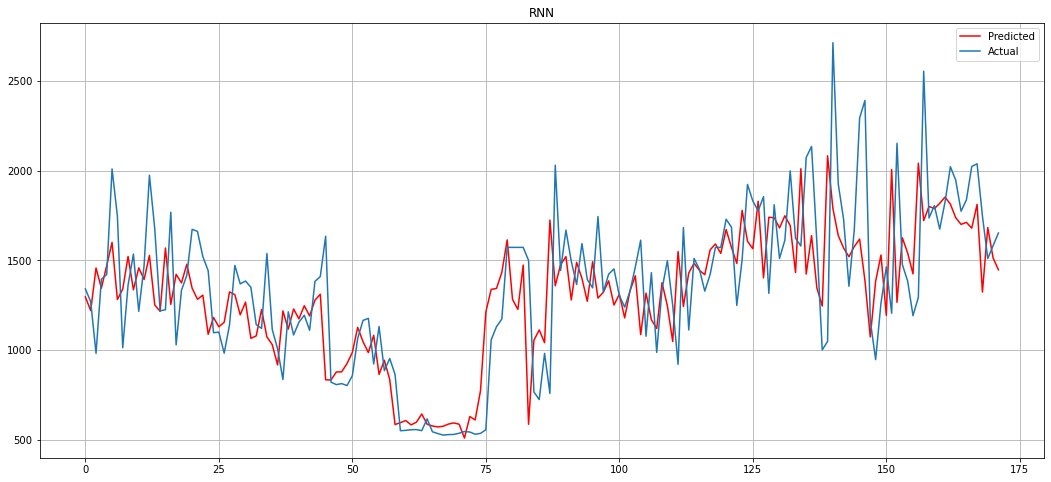

In [14]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.savefig('1 - RNN.jpg', dpi=200)
plt.show()

## 3.2 LSTM

In [15]:
lstm_preds = scaler_y.inverse_transform(LSTM_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['LSTM'] = evaluate(y_test_actual, lstm_preds)
evaluate(y_test_actual, lstm_preds)

{'mae': 245.0455033061508,
 'rmse': 330.22066113057963,
 'mape': 0.20631836865629447,
 'r2': 0.4376871431954429}

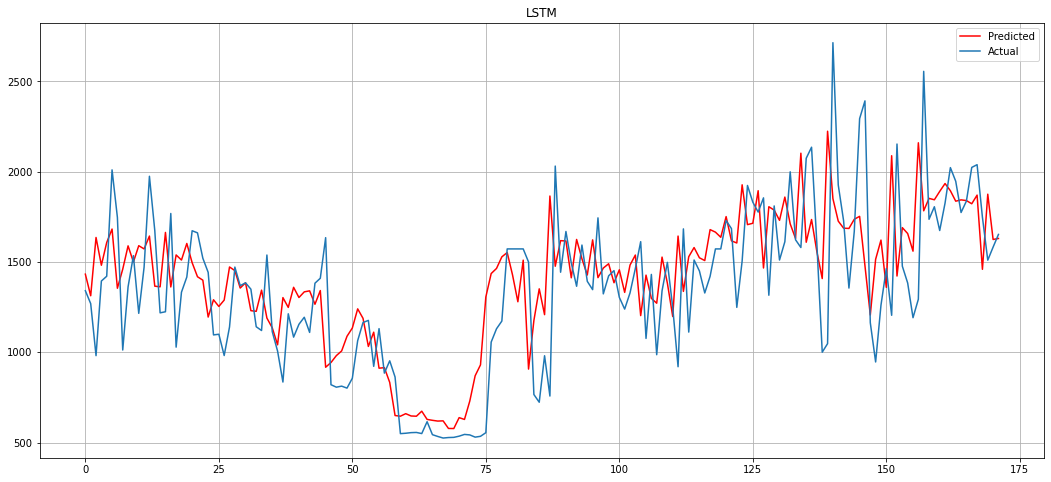

In [16]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.savefig('2 - LSTM.jpg', dpi=200)
plt.show()

## 3.3 GRU

In [17]:
gru_preds = scaler_y.inverse_transform(GRU_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['GRU'] = evaluate(y_test_actual, gru_preds)
evaluate(y_test_actual, gru_preds)

{'mae': 242.1411255141513,
 'rmse': 327.71007621259713,
 'mape': 0.20362727097646338,
 'r2': 0.4462048879187045}

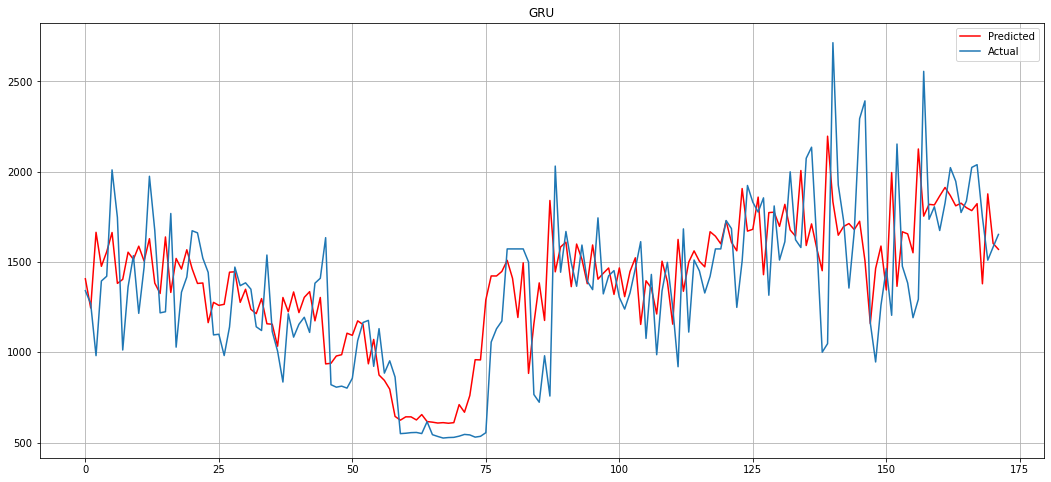

In [18]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.savefig('3 - GRU.jpg', dpi=200)
plt.show()

# 4. Rolling Forecast with RNN, LSTM, GRU
Instead of forecasting out a very long sequence out `2010-06-01` to `2010-11-23`, 175 days between them is a medium-length sequence and can run into vanishing gradient problems. Personally, LSTMs and GRUs can such long-term dependecies readily, but we can also experiment with a rolling forecasting scheme to see if this results in better forecasts.

By rolling, we mean that we train on initial train set, predict next month. Expand training window to include the predictions from next month.
1. Predict one month ahead
2. Create features based on predictions
3. Expand training window to include the predictions

Repeated till all predictions are reached

In [19]:
chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:1096,1:])
scaler_y = scaler.fit(chosen.iloc[:1096,0].values.reshape(-1,1))

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

train = scaled[:1078]
val = scaled[1078:1256]
test = scaled[1256:]

x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

Recreate the dataset, and write some helper functions for preprocessing, forecasting

In [20]:
## Helper Function
i = 0
def train_test_split(df, i=0):
    chosen = create_lags(df)
    chosen.dropna(inplace=True)
    x_scaled = scaler_x.transform(chosen.iloc[:,1:])
    y_scaled = scaler_y.transform(chosen.loc[:,['y']])

    scaled = np.hstack((x_scaled, y_scaled))
    scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

    train = scaled[:1078+i]
    val = scaled[1078+i:1256+i]
    test = scaled[1256+i:]
    
    x_train = train.drop(["y"],axis=1)
    y_train = train["y"]
    x_val = val.drop(["y"],axis=1)
    y_val = val["y"]
    x_test = test.drop(["y"],axis=1)
    y_test = test["y"]

    n_features = len(x_train.columns)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(df_resample, i)
print(x_test.shape)

(179, 7)


Use a simple for loop here of train, predict, re-train, predict our forecast

In [21]:
TIME_STEPS, N_FEATURES = 7, 7
rnn, lstm, gru = list(), list(), list()

for i in range(0, len(x_test), 30):
    temp = df_resample.copy()
    x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(temp, i)
    
    x_train_np = create_features(x_train, TIME_STEPS, N_FEATURES)
    x_val_np = create_features(x_val, TIME_STEPS, N_FEATURES)
    x_test_np = create_features(x_test, TIME_STEPS, N_FEATURES)
    #print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
    y_test = y_test[:x_test_np.shape[0]]
    y_train = y_train[:x_train_np.shape[0]]
    y_val = y_val[:x_val_np.shape[0]]
    #print(y_train.shape, y_val.shape, y_test.shape)
    
    if y_test.shape[0] != 0:
        RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
        LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
        GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

        RNN_preds = RNN_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(RNN_preds)
        rnn.extend(yhat_actual.flatten()[:30])
        LSTM_preds = LSTM_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(LSTM_preds)
        lstm.extend(yhat_actual.flatten()[:30])
        GRU_preds = GRU_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(GRU_preds)
        gru.extend(yhat_actual.flatten()[:30])

In [22]:
resultsDict['RNN Rolling'] = evaluate(y_test_actual[7:], rnn)
evaluate(y_test_actual[7:], rnn)

{'mae': 449.3040098178924,
 'rmse': 565.7741945916592,
 'mape': 0.42435938843491205,
 'r2': 0.4375820686007208}

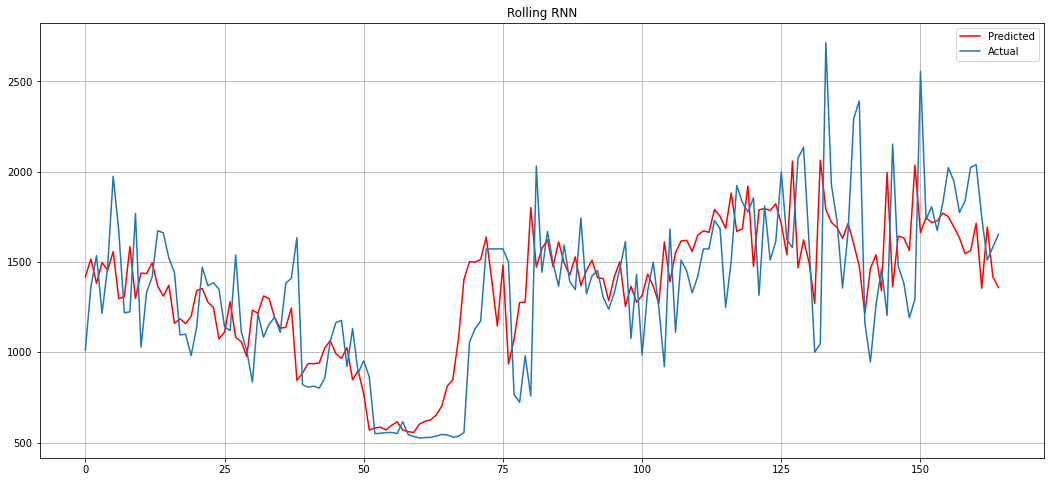

In [23]:
plt.figure(figsize=(18,8))
plt.plot(rnn, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling RNN')
plt.grid(True)
plt.savefig('4 - RNN (Rolling).jpg', dpi=200)
plt.show()

In [24]:
resultsDict['LSTM Rolling'] = evaluate(y_test_actual[7:], lstm)
evaluate(y_test_actual[7:], lstm)

{'mae': 455.6057396833748,
 'rmse': 573.6085996598292,
 'mape': 0.43395708562761903,
 'r2': 0.45969034699215217}

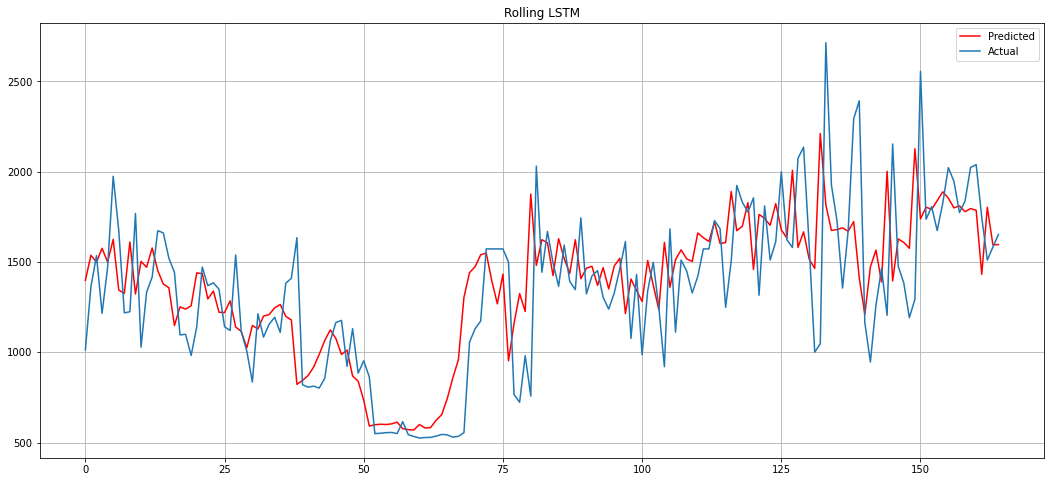

In [25]:
plt.figure(figsize=(18,8))
plt.plot(lstm, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling LSTM')
plt.grid(True)
plt.savefig('5 - LSTM (Rolling).jpg', dpi=200)
plt.show()

In [26]:
resultsDict['GRU Rolling'] = evaluate(y_test_actual[7:], gru)
evaluate(y_test_actual[7:], gru)

{'mae': 452.94009362231907,
 'rmse': 570.4454290011084,
 'mape': 0.43201323862169244,
 'r2': 0.4606267145973193}

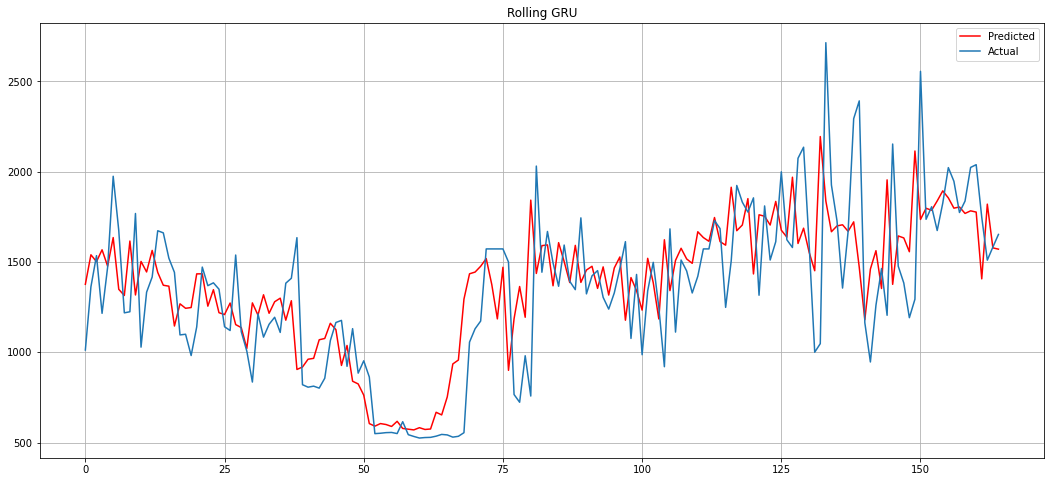

In [27]:
plt.figure(figsize=(18,8))
plt.plot(gru, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling GRU')
plt.grid(True)
plt.savefig('6 - GRU (Rolling).jpg', dpi=200)
plt.show()

# 5. Results

In [28]:
resultsDict

{'RNN': {'mae': 231.60665597637197,
  'rmse': 323.2633893813319,
  'mape': 0.17722888619882202,
  'r2': 0.4611317788380921},
 'LSTM': {'mae': 245.0455033061508,
  'rmse': 330.22066113057963,
  'mape': 0.20631836865629447,
  'r2': 0.4376871431954429},
 'GRU': {'mae': 242.1411255141513,
  'rmse': 327.71007621259713,
  'mape': 0.20362727097646338,
  'r2': 0.4462048879187045},
 'RNN Rolling': {'mae': 449.3040098178924,
  'rmse': 565.7741945916592,
  'mape': 0.42435938843491205,
  'r2': 0.4375820686007208},
 'LSTM Rolling': {'mae': 455.6057396833748,
  'rmse': 573.6085996598292,
  'mape': 0.43395708562761903,
  'r2': 0.45969034699215217},
 'GRU Rolling': {'mae': 452.94009362231907,
  'rmse': 570.4454290011084,
  'mape': 0.43201323862169244,
  'r2': 0.4606267145973193}}

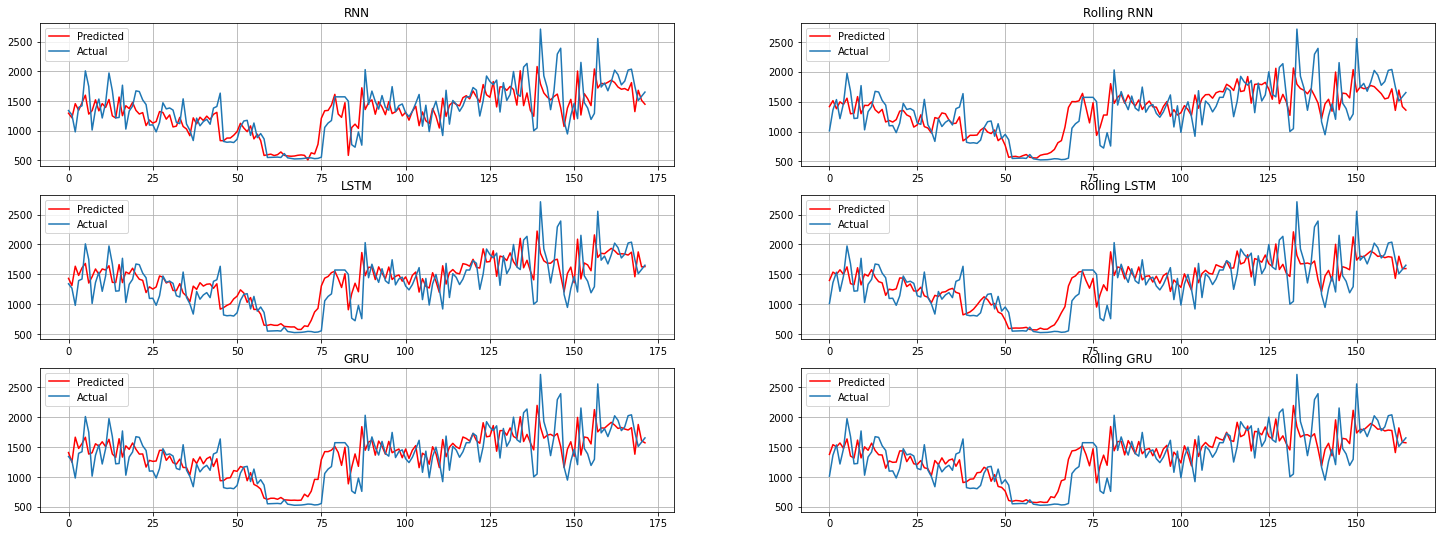

In [29]:
fig,a =  plt.subplots(3,2, figsize=(25,9))

a[0][0].plot(rnn_preds, "r-", label="Predicted")
a[0][0].plot(y_test_actual, label="Actual")
a[0][0].legend()
a[0][0].grid(True)
a[0][0].set_title('RNN')
a[0][1].plot(rnn, "r-", label="Predicted")
a[0][1].plot(y_test_actual[7:], label="Actual")
a[0][1].legend()
a[0][1].grid(True)
a[0][1].set_title('Rolling RNN')
a[1][0].plot(lstm_preds, "r-", label="Predicted")
a[1][0].plot(y_test_actual, label="Actual")
a[1][0].legend()
a[1][0].grid(True)
a[1][0].set_title('LSTM')
a[1][1].plot(lstm, "r-", label="Predicted")
a[1][1].plot(y_test_actual[7:], label="Actual")
a[1][1].legend()
a[1][1].grid(True)
a[1][1].set_title('Rolling LSTM')
a[2][0].plot(gru_preds, "r-", label="Predicted")
a[2][0].plot(y_test_actual, label="Actual")
a[2][0].legend()
a[2][0].grid(True)
a[2][0].set_title('GRU')
a[2][1].plot(gru, "r-", label="Predicted")
a[2][1].plot(y_test_actual[7:], label="Actual")
a[2][1].legend()
a[2][1].grid(True)
a[2][1].set_title('Rolling GRU')
plt.savefig('Summary.jpg', dpi=200)
plt.show()